# Rekomendasi Peneliti Berdasarkan Rekam Jejak Publikasi  


# 1. Import Libraries
---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')

from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

# 2. Load & Preprocessing Dataset
---

In [2]:
# Load Dataset
df = pd.read_csv('dataset/arXiv_scientific dataset.csv')
df = df[df['summary_word_count'] >= 30]
df['content'] = df['title'].astype(str) + " . " + df['summary'].astype(str) +  " . "  + df['category'].astype(str)

print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 135979 entries, 0 to 136237
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   id                  135979 non-null  object
 1   title               135979 non-null  object
 2   category            135979 non-null  object
 3   category_code       135979 non-null  object
 4   published_date      135979 non-null  object
 5   updated_date        135979 non-null  object
 6   authors             135979 non-null  object
 7   first_author        135979 non-null  object
 8   summary             135979 non-null  object
 9   summary_word_count  135979 non-null  int64 
 10  content             135979 non-null  object
dtypes: int64(1), object(10)
memory usage: 12.4+ MB
None


,id,title,category,category_code,published_date,updated_date,authors,first_author,summary,summary_word_count,content
0,cs-9308101v1,Dynamic Backtracking,Artificial Intelligence,cs.AI,8/1/93,8/1/93,['M. L. Ginsberg'],'M. L. Ginsberg',Because of their occasional need to return to ...,79,Dynamic Backtracking . Because of their occasi...
1,cs-9308102v1,A Market-Oriented Programming Environment and ...,Artificial Intelligence,cs.AI,8/1/93,8/1/93,['M. P. Wellman'],'M. P. Wellman',Market price systems constitute a well-underst...,119,A Market-Oriented Programming Environment and ...
2,cs-9309101v1,An Empirical Analysis of Search in GSAT,Artificial Intelligence,cs.AI,9/1/93,9/1/93,"['I. P. Gent', 'T. Walsh']",'I. P. Gent',We describe an extensive study of search in GS...,167,An Empirical Analysis of Search in GSAT . We d...
3,cs-9311101v1,The Difficulties of Learning Logic Programs wi...,Artificial Intelligence,cs.AI,11/1/93,11/1/93,"['F. Bergadano', 'D. Gunetti', 'U. Trinchero']",'F. Bergadano',As real logic programmers normally use cut (!)...,174,The Difficulties of Learning Logic Programs wi...
4,cs-9311102v1,Software Agents: Completing Patterns and Const...,Artificial Intelligence,cs.AI,11/1/93,11/1/93,"['J. C. Schlimmer', 'L. A. Hermens']",'J. C. Schlimmer',To support the goal of allowing users to recor...,187,Software Agents: Completing Patterns and Const...


# 3. Exploratory Data Analysis (EDA)
---

In [3]:
print(f"Total Article: {len(df)}")
print(f"Average Content Length: {df['content'].str.len().mean():.2f} words")
print(f"Jumlah Missing Values:\n{df.isnull().sum()}")

Total Article: 135979
Average Content Length: 1240.40 words
Jumlah Missing Values:
id                    0
title                 0
category              0
category_code         0
published_date        0
updated_date          0
authors               0
first_author          0
summary               0
summary_word_count    0
content               0
dtype: int64


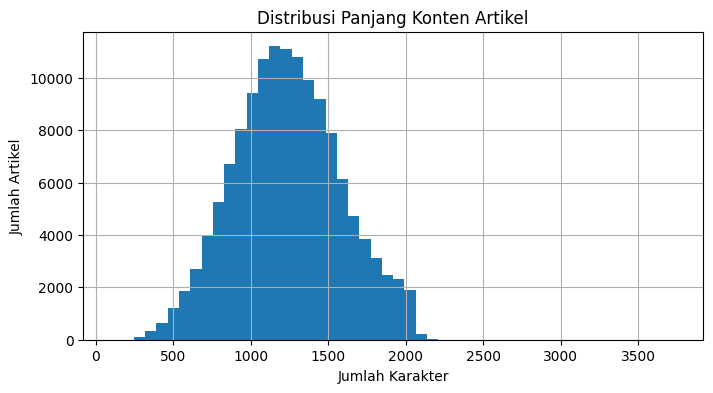

In [4]:
df['content_length'] = df['content'].str.len()

plt.figure(figsize=(8, 4))
df['content_length'].hist(bins=50)
plt.title("Distribusi Panjang Konten Artikel")
plt.xlabel("Jumlah Karakter")
plt.ylabel("Jumlah Artikel")
plt.show()

# 4. Author Profiling (Gabung Publikasi per Peneliti)
---

In [5]:
df['first_author_clean'] = df['first_author'].astype(str).str.strip().str.replace("'", "").str.replace('"', '')
author_texts = df.groupby("first_author_clean")["content"].apply(lambda texts: " ".join(texts)).reset_index()
print(f"Total Unique Researcher: {len(author_texts)}")
author_texts.head()

Total Unique Researcher: 77638


,first_author_clean,content
0,Abhishake,Gradient-Based Non-Linear Inverse Learning . W...
1,Abhishek,Fine-Grained Entity Type Classification by Joi...
2,Adaptive Agent Team,Human-Timescale Adaptation in an Open-Ended Ta...
3,Aishwaryaprajna,Evolutionary Algorithms for Solving Unconstrai...
4,Aixiang,MSTGD:A Memory Stochastic sTratified Gradient ...


# 5. Sentence Embedding
---

In [6]:
model = SentenceTransformer('all-MiniLM-L6-v2', device='cuda')

# 6. Batch Processing Embedding
---

In [7]:
embeddings = []
batch_size = 1000

for i in tqdm(range(0, len(author_texts), batch_size)):
    batch_texts = author_texts['content'].iloc[i:i+batch_size].tolist()
    batch_embeddings = model.encode(batch_texts, show_progress_bar=False)
    embeddings.extend(batch_embeddings)

author_texts['embedding'] = embeddings

100%|██████████| 78/78 [02:31<00:00,  1.94s/it]


# 7. Sistem Rekomendasi Peneliti
---

In [8]:
def recommend_researcher(query, top_n=5):
    query_emb = model.encode(query).reshape(1, -1)
    embeddings_array = np.vstack(author_texts['embedding'])
    
    sims = cosine_similarity(query_emb, embeddings_array)[0]
    top_indices = np.argsort(sims)[::-1][:top_n]
    
    recommendations = author_texts.iloc[top_indices][['first_author_clean']].copy()
    recommendations['similarity'] = sims[top_indices]
    
    return recommendations

In [9]:
query = "deep learning for healthcare"
recommended = recommend_researcher(query)
recommended

,first_author_clean,similarity
45199,Muhammad Imran Razzak,0.748852
20854,Geert Litjens,0.716909
61268,Stylianos Serghiou,0.711718
8258,Benjamin Shickel,0.697667
38756,Maciej A. Mazurowski,0.697566


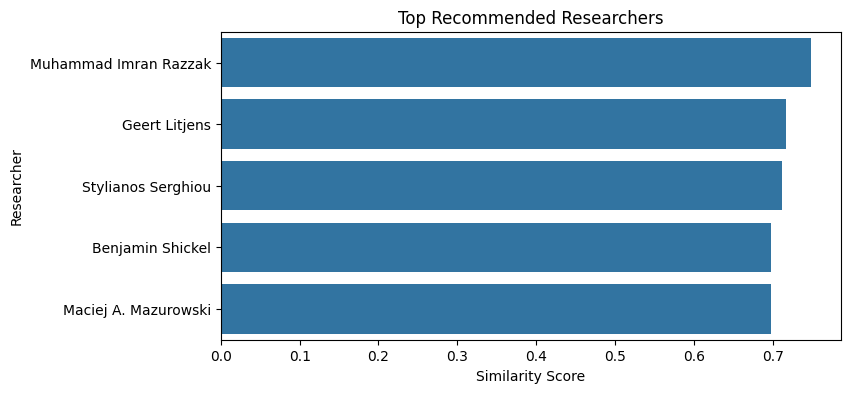

In [10]:
plt.figure(figsize=(8, 4))
sns.barplot(x=recommended['similarity'], y=recommended['first_author_clean'], orient='h')
plt.xlabel('Similarity Score')
plt.ylabel('Researcher')
plt.title('Top Recommended Researchers')
plt.show()

# 8. Verifikasi Peneliti
---

In [11]:
recommended['author_clean'] = recommended['first_author_clean'].astype(str).str.strip().str.replace("'", "").str.replace('"', '')

query_emb = model.encode(query)
similarity_threshold = 0.5
results = []

for author in recommended['author_clean']:
    df_author = df[df['first_author_clean'] == author][['title', 'summary', 'category']].copy()
    
    if df_author.empty:
        total_pub = 0
        relevant_pub = 0
        relevance_ratio = 0
        relevant_titles = []
    else:
        df_author['summary_emb'] = df_author['summary'].astype(str).apply(lambda x: model.encode(x))
        df_author['similarity'] = df_author['summary_emb'].apply(lambda x: cosine_similarity([query_emb], [x])[0][0])
        df_author['relevant'] = df_author['similarity'] >= similarity_threshold

        total_pub = len(df_author)
        relevant_pub = df_author['relevant'].sum()
        relevance_ratio = relevant_pub / total_pub if total_pub > 0 else 0
        relevant_titles = df_author[df_author['relevant']]['title'].tolist()

    results.append({
        'author': author,
        'total_pub': total_pub,
        'relevant_pub': relevant_pub,
        'relevance_ratio': relevance_ratio,
        'matched_titles': relevant_titles
    })

results_df = pd.DataFrame(results)
pd.set_option('display.max_colwidth', None)
results_df


,author,total_pub,relevant_pub,relevance_ratio,matched_titles
0,Muhammad Imran Razzak,1,1,1.000000,"[Deep Learning for Medical Image Processing: Overview, Challenges and\n Future]"
1,Geert Litjens,1,1,1.000000,[A Survey on Deep Learning in Medical Image Analysis]
2,Stylianos Serghiou,1,1,1.000000,[Deep Learning for Epidemiologists: An Introduction to Neural Networks]
3,Benjamin Shickel,6,4,0.666667,"[Deep EHR: A Survey of Recent Advances in Deep Learning Techniques for\n Electronic Health Record (EHR) Analysis, Sequential Interpretability: Methods, Applications, and Future Direction\n for Understanding Deep Learning Models in the Context of Sequential Data, Dynamic Predictions of Postoperative Complications from Explainable,\n Uncertainty-Aware, and Multi-Task Deep Neural Networks, DeepSOFA: A Continuous Acuity Score for Critically Ill Patients using\n Clinically Interpretable Deep Learning]"
4,Maciej A. Mazurowski,1,1,1.000000,[Deep learning in radiology: an overview of the concepts and a survey of\n the state of the art]
